# Display images to know what we are working with

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
256 256 256


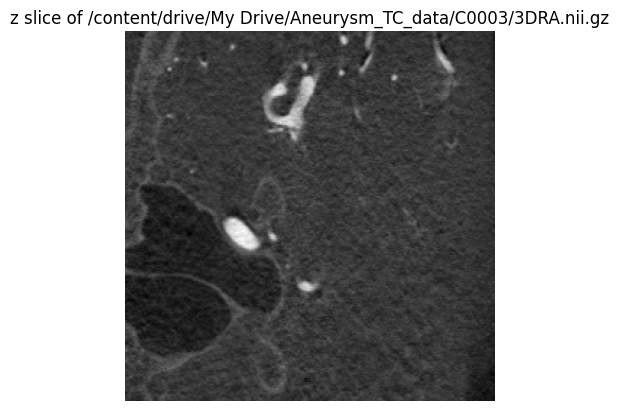

256 256 256


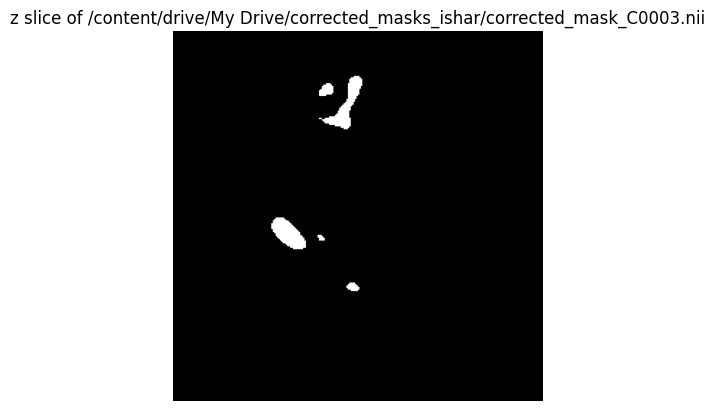

520 491 367


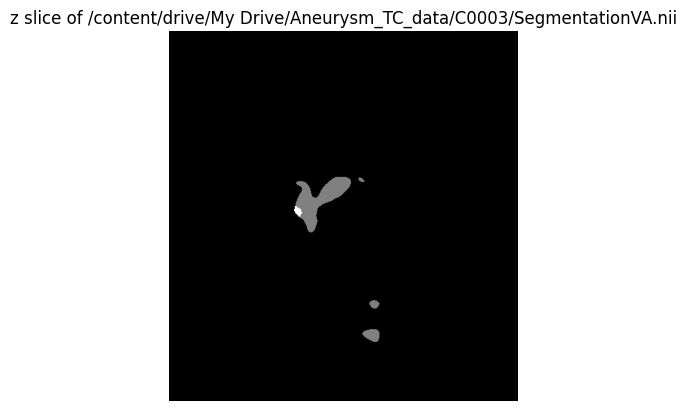

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# Function to load and display a NIfTI image
def display_nifti(file_path):
    # Load the NIfTI file
    img = nib.load(file_path)
    data = img.get_fdata()  # Convert to a NumPy array

    print(data.shape[0], data.shape[1], data.shape[2])

    # Select the middle slice (assuming the image is 3D)
    z_slice = data.shape[2] // 1 - 150  # Middle slice in the Z-axis

    # Plot the image slice
    plt.imshow(data[:, :, z_slice], cmap="gray", origin="lower")
    plt.title(f"z slice of {file_path}")
    plt.axis("off")
    plt.show()



# Example usage
drive.mount('/content/drive')
file_path = r"/content/drive/My Drive/Aneurysm_TC_data/C0003/3DRA.nii.gz"  # Change to your actual file path
file_path2 = r"/content/drive/My Drive/Aneurysm_TC_data/C0003/SegmentationVA.nii"  # Change to your actual file path
file_path3 = r"/content/drive/My Drive/corrected_masks_ishar/corrected_mask_C0003.nii"  # Change to your actual file path
display_nifti(file_path)
display_nifti(file_path3)
display_nifti(file_path2)

# Load the intensity values in a 3D matrix for further purposes

In [ ]:
# Use the corrected masks - as they are in right order and right dimension

def construct_matrix(file_path):
    # Load the NIfTI file
    img = nib.load(file_path)
    data = img.get_fdata()  # Convert to NumPy array

    # Print shape info
    print(f"Matrix shape: {data.shape}")

    # Create and return a copy of the data (ensuring it's a NumPy array)
    return np.array(data, dtype=np.uint8)  # Convert to uint8 if intensities are discrete (0,1,2)

matrix_corr_mask = []
matrix_corr_mask = construct_matrix(file_path3)
print(f"Unique values in the corrected mask matrix: ",np.unique(matrix_corr_mask))

# Keep only the '2' values
matrix_aneurysm = np.zeros_like(matrix_corr_mask)
matrix_aneurysm[matrix_corr_mask == 2] = 2
print(f"Unique values in the aneurysm matrix: ",np.unique(matrix_aneurysm))

matrix_vessels = np.zeros_like(matrix_corr_mask)
matrix_vessels[matrix_corr_mask == 1] = 1
print(f"Unique values in the surface boundary green matrix: ",np.unique(matrix_vessels))


Matrix shape: (256, 256, 256)
Unique values in the corrected mask matrix:  [0 1 2]
Unique values in the aneurysm matrix:  [0 2]
Unique values in the surface boundary green matrix:  [0 1]


# Visualize aneurysm

In [ ]:
import numpy as np
import plotly.graph_objects as go
from scipy.ndimage import generate_binary_structure, binary_dilation

# Define 26-connectivity structure in 3D (one pixel away in any direction)
structure = generate_binary_structure(3, 3)  # 3D, full 26-neighborhood

# Find coordinates for aneurysm points (value = 2)
x, y, z = np.where(matrix_corr_mask == 2)

# Find coordinates for correlation mask points (value = 1)
x1, y1, z1 = np.where(matrix_corr_mask == 1)

# Create a mask of neighboring points that touch value = 1
dilated_mask = binary_dilation(matrix_corr_mask == 1, structure=structure)

print("Unique values in dilated_mask:", np.unique(dilated_mask))

# Find aneurysm points (value = 2) that have at least one 1-neighbor
green_mask = (matrix_corr_mask == 2) & dilated_mask
x_green, y_green, z_green = np.where(green_mask)

# Create figure
fig = go.Figure()

# Add correlation mask points (gray)
fig.add_trace(go.Scatter3d(
    x=x1, y=y1, z=z1,
    mode='markers',
    marker=dict(size=5, color='gray', opacity=0.5),
    name='Vessel Data'
))

# Add aneurysm points (red)
fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.8),
    name='Aneurysm Data'
))

# Add aneurysm points with neighboring 1s (green)
fig.add_trace(go.Scatter3d(
    x=x_green, y=y_green, z=z_green,
    mode='markers',
    marker=dict(size=5, color='green', opacity=0.8),
    name='Aneurysm-Vessel Interface Data'
))


# Update layout
fig.update_layout(scene=dict(aspectmode='data'))

# Show plot
fig.show()


Unique values in dilated_mask: [False  True]


# Find vector perpendicular to surface of boundary

In [ ]:
from sklearn.decomposition import PCA

#Create matrix with surface points on the aneurysm-vessel boundary
surface_matrix = np.zeros_like(matrix_aneurysm)
surface_matrix = green_mask

# Get surface points
surface_points = np.argwhere(surface_matrix == 1)

# Compute PCA
pca = PCA(n_components=3)
pca.fit(surface_points)

# The normal is the eigenvector corresponding to the smallest eigenvalue
normal_vector = pca.components_[-1]  # Smallest component gives normal

# Ensure it's a unit vector
normal_vector /= np.linalg.norm(normal_vector)

# Choose a point to originate the normal (e.g., mean of surface)
origin = np.mean(surface_points, axis=0)

# Plot using Plotly
fig = go.Figure()

# Add surface points
fig.add_trace(go.Scatter3d(
    x=surface_points[:, 0], y=surface_points[:, 1], z=surface_points[:, 2],
    mode='markers', marker=dict(size=3, color='green'), name="Surface Points"
))

# Add the corrected normal vector
fig.add_trace(go.Cone(
    x=[origin[0]], y=[origin[1]], z=[origin[2]],
    u=[normal_vector[0]], v=[normal_vector[1]], w=[normal_vector[2]],
    sizemode="scaled", sizeref=5, anchor="tail",
    colorscale="reds", name="Corrected Normal"
))

# Show figure
fig.update_layout(scene=dict(aspectmode='data'))
fig.show()

# Create a local coordinate system x'y'n'

In [ ]:
# Step 1: Compute local coordinate system
normal_vector /= np.linalg.norm(normal_vector)  # Normalize normal

# Pick a reference vector for basis computation
if abs(normal_vector[0]) < 0.9:
    reference_vector = np.array([1, 0, 0])
else:
    reference_vector = np.array([0, 1, 0])

# Compute basis vectors
basis_vector_1 = np.cross(normal_vector, reference_vector)
basis_vector_1 /= np.linalg.norm(basis_vector_1)

basis_vector_2 = np.cross(normal_vector, basis_vector_1)
basis_vector_2 /= np.linalg.norm(basis_vector_2)

# Construct the transformation matrix (Global -> Local)
T = np.column_stack([basis_vector_1, basis_vector_2, normal_vector]).T  # Transpose to map to local

# Step 2: Transform all surface points into the local coordinate system
origin = np.mean(surface_points, axis=0)
centered_points = surface_points - origin
local_points = (T @ centered_points.T).T  # Transform each point to local [x', y', n']

c0018 problematic ..?

# Make a scatter plot of the neck points in the local [x',y'] coordinate system representation


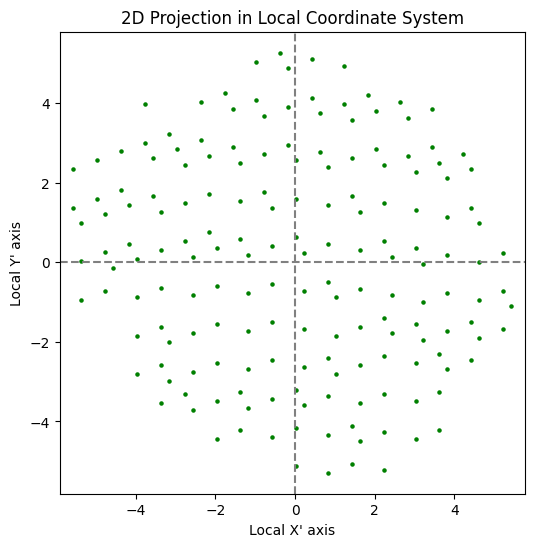

In [ ]:
# Extract x' and y' coordinates for the scatter plot
x_prime = local_points[:, 0]  # x' coordinates
y_prime = local_points[:, 1]  # y' coordinates

# Step 3: Plot the 2D scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(x_prime, y_prime, c='green', s=5)
plt.axhline(0, color='gray', linestyle='dashed')
plt.axvline(0, color='gray', linestyle='dashed')
plt.xlabel("Local X' axis")
plt.ylabel("Local Y' axis")
plt.title("2D Projection in Local Coordinate System")
plt.axis("equal")
plt.show()


# Concave hull for a smooth surface representation




In [ ]:
pip install -U concave_hull

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.1/116.1 kB 2.9 MB/s eta 0:00:00


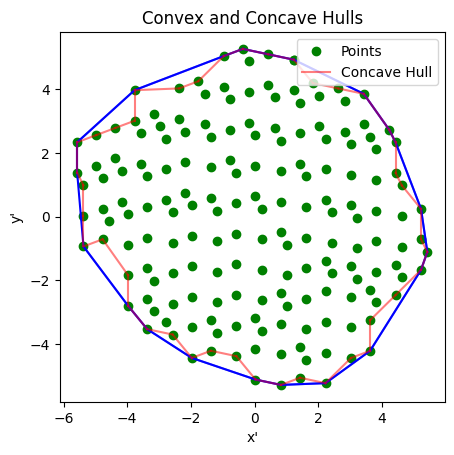

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

from concave_hull import (  # noqa: F401
    concave_hull,
    concave_hull_indexes,
    convex_hull_indexes,
)

projected_2d = local_points[:, :2]  # Extract x and y coordinates

# Your 2D points (make sure 'projected_2d' is already defined)
points = np.array(projected_2d)

# Add the first point to the end of the array to close the loop
points = np.vstack([points, points[0]])

# Compute Convex Hull using scipy
convex_hull = ConvexHull(points[:, :2])  # points are already 2D (N-by-2)

# Plot the points
plt.plot(points[:, 0], points[:, 1], "o", label='Points', color = 'green')

# Plot the Convex Hull edges
for simplex in convex_hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], "b-", alpha=1, label='Convex Hull' if simplex[0] == 0 else "")

# Compute and plot the Convex Hull boundary using the indexes
hull = convex_hull_indexes(points[:, :2])
for i, j in zip(hull[:-1], hull[1:]):
    plt.plot(
        [points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], "b-", alpha=0.5
    )

# Compute the Concave Hull and plot it
idxes = concave_hull_indexes(
    points[:, :2],
    length_threshold=0,
    # convex_hull_indexes=convex_hull.vertices.astype(np.int32),
)

# Plot the Concave Hull edges
for f, t in zip(idxes[:-1], idxes[1:]):
    seg = points[[f, t]]
    plt.plot(seg[:, 0], seg[:, 1], "r-", alpha=0.5, label='Concave Hull' if f == 0 else "")

# Close the Concave Hull polygon by adding the final segment
plt.plot([points[idxes[-1], 0], points[idxes[0], 0]],
         [points[idxes[-1], 1], points[idxes[0], 1]],
         "r-", alpha=0.5, label = 'Concave Hull')

# Set aspect ratio to be equal, so the hulls are not distorted
plt.gca().set_aspect("equal")

# Add labels and legend
plt.xlabel('x\'')
plt.ylabel('y\'')
plt.title('Convex and Concave Hulls')

# Show the plot
plt.legend()
#plt.show()

# Fill in concave hull


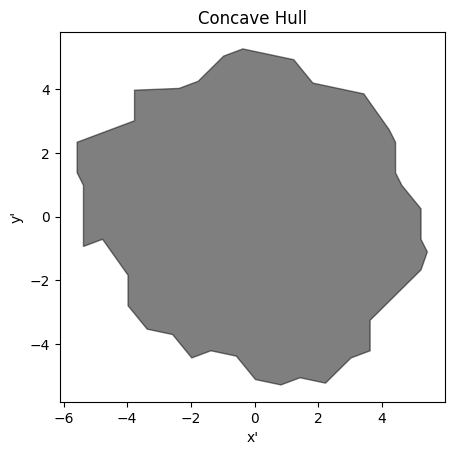

In [ ]:
# Fill the area inside the Concave Hull with black color
concave_x = points[idxes, 0]  # X coordinates of the concave hull points
concave_y = points[idxes, 1]  # Y coordinates of the concave hull points

plt.fill(concave_x, concave_y, color='black', alpha=0.5)  # Fill with black color (adjust alpha for transparency)

# Set aspect ratio to be equal, so the hulls are not distorted
plt.gca().set_aspect("equal")

# Add labels and legend
plt.xlabel('x\'')
plt.ylabel('y\'')
plt.title('Concave Hull')

# Show the plot
plt.show()

# Project the 2D image onto a 1D line for angles [0, 180]

In [ ]:
# Get the concave hull points
concave_hull_points = points[idxes]

# Function to project points onto a 1D line at a given angle
def project_onto_line(points, angle):
    # Convert angle to radians
    angle_rad = np.radians(angle)

    # Define the unit vector for the projection direction
    direction = np.array([np.cos(angle_rad), np.sin(angle_rad)])

    # Project each point of the concave hull onto the direction (dot product)
    projection = np.dot(points, direction)

    return projection

# Define angles to project the concave hull onto (0 to 180 degrees)
angles = np.linspace(0, 180, 181)  # From 0 to 180 degrees
projections = []
projection_ranges = []

# Plot projections for each angle and find the angle with the shortest projection range
for angle in angles:
    # Project the concave hull onto the 1D line at each angle
    projection = project_onto_line(concave_hull_points, angle)

    # Calculate the range of the projection (max - min)
    projection_range = np.max(projection) - np.min(projection)
    projection_ranges.append(projection_range)

# print(projection_ranges)
angles_ranges = [(angles[i], projection_ranges[i]) for i in range (0, 181)]
angles_ranges_sorted = sorted(angles_ranges, key=lambda x: x[1])
print(angles_ranges_sorted)

# Find the angle with the shortest 1D projection
shortest_projection_angle = angles[np.argmin(projection_ranges)]
print(f"The angle with the shortest 1D projection is: {shortest_projection_angle}°")
print(f"The length of the shortest 1D projection is: {min(projection_ranges)}°")

# Find the angle with the longest 1D projection
longest_projection_angle = angles[np.argmax(projection_ranges)]
print(f"The angle with the longest 1D projection is: {longest_projection_angle}°")
print(f"The length of the longest 1D projection is: {max(projection_ranges)}°")

[(64.0, 9.823020670755213), (63.0, 9.842805908576494), (65.0, 9.842895116502497), (62.0, 9.85959293236862), (66.0, 9.85983015425236), (61.0, 9.873376628641527), (67.0, 9.873761792222918), (60.0, 9.8841527987478), (68.0, 9.884685786702288), (59.0, 9.891918160161637), (69.0, 9.892598810135926), (58.0, 9.896670347478727), (70.0, 9.897498452140237), (71.0, 9.899383220236807), (57.0, 9.903158358960791), (37.0, 9.918152098200054), (72.0, 9.925288156177395), (56.0, 9.930963647916254), (38.0, 9.931660912807937), (36.0, 9.939247310789572), (39.0, 9.942144447291618), (55.0, 9.955743869141155), (73.0, 9.95801027193296), (40.0, 9.961513766287133), (35.0, 9.96782882134191), (54.0, 9.97749147434006), (41.0, 9.982495610972911), (74.0, 9.987699081294284), (53.0, 9.996199838981752), (42.0, 10.000436690792982), (34.0, 10.010050545460201), (52.0, 10.011863264317126), (75.0, 10.014345540762429), (43.0, 10.01533154072063), (51.0, 10.024476979115093), (44.0, 10.027175623640282), (50.0, 10.034037141115931), 

# Find projection vector for 3D case

In [ ]:
# Step 1: Calculate the unit vector in the 2D plane corresponding to the projection angle
shortest_projection_angle_rad = np.deg2rad(angles_ranges_sorted[0][0])  # Convert theta to radians
u_2d_local = np.array([np.cos(shortest_projection_angle_rad), np.sin(shortest_projection_angle_rad)])
print(u_2d_local)

# Transformation matrix (local to global)
T_inv = np.linalg.inv(T)

# Step 2: Transform the 2D local vector back to the global coordinate system
u_2d_global = T_inv @ np.append(u_2d_local, 0)  # Append 0 for the normal component (since u_2d_local is 2D)
print(u_2d_global)

[0.43837115 0.89879405]
[-0.862443   -0.46563541 -0.19843321]


In [ ]:
# make a list with 3D projection vectors sorted from most optimal projection vector to least optimal

shortest_projection_angle_rad_list = np.deg2rad(angles_ranges_sorted)

u_2d_local_list = []
for angle in shortest_projection_angle_rad_list:
    u_2d_local_list.append(np.array([np.cos(angle[0]), np.sin(angle[0])]))

u_2d_global_list = []
for u_2d_local in u_2d_local_list:
    u_2d_global_list.append(T_inv @ np.append(u_2d_local, 0))

# Compute the list with global projection directions
projection_direction_list = []
for u_2d_global in u_2d_global_list:
    projection_direction_list.append(np.cross(normal_vector, u_2d_global))
    projection_direction_list[-1] /= np.linalg.norm(projection_direction_list[-1])  # Normalize

print(projection_direction_list)

[array([-0.42064156,  0.44131055,  0.79265735]), array([-0.4356292 ,  0.43311688,  0.78907349]), array([-0.40552578,  0.4493698 ,  0.79599976]), array([-0.45048414,  0.42479128,  0.78524927]), array([-0.39028649,  0.45729216,  0.7990997 ]), array([-0.46520186,  0.41633628,  0.78118585]), array([-0.3749283 ,  0.46507523,  0.80195623]), array([-0.47977788,  0.40775446,  0.77688448]), array([-0.35945591,  0.47271663,  0.80456848]), array([-0.49420775,  0.39904843,  0.77234646]), array([-0.34387403,  0.48021403,  0.80693564]), array([-0.50848708,  0.39022085,  0.76757317]), array([-0.3281874 ,  0.48756516,  0.80905701]), array([-0.3124008 ,  0.49476777,  0.81093193]), array([-0.52261152,  0.38127441,  0.76256608]), array([-0.7663353 ,  0.18181653,  0.61617608]), array([-0.29651903,  0.50181967,  0.81255983]), array([-0.53657677,  0.37221183,  0.7573267 ]), array([-0.75614025,  0.19252617,  0.62544831]), array([-0.77629691,  0.17105151,  0.60671615]), array([-0.74571488,  0.20317716,  0.634

In [ ]:
import numpy as np
import plotly.graph_objects as go
from scipy.ndimage import generate_binary_structure, binary_dilation

# Define 26-connectivity structure in 3D (one pixel away in any direction)
structure = generate_binary_structure(3, 3)  # 3D, full 26-neighborhood

# Find coordinates for aneurysm points (value = 2)
x, y, z = np.where(matrix_corr_mask == 2)

# Find coordinates for correlation mask points (value = 1)
x1, y1, z1 = np.where(matrix_corr_mask == 1)

# Create a mask of neighboring points that touch value = 1
dilated_mask = binary_dilation(matrix_corr_mask == 1, structure=structure)

print("Unique values in dilated_mask:", np.unique(dilated_mask))

# Find aneurysm points (value = 2) that have at least one 1-neighbor
green_mask = (matrix_corr_mask == 2) & dilated_mask
x_green, y_green, z_green = np.where(green_mask)

# Create figure
fig = go.Figure()

# Add correlation mask points (gray)
fig.add_trace(go.Scatter3d(
    x=x1, y=y1, z=z1,
    mode='markers',
    marker=dict(size=5, color='gray', opacity=0.2),
    name='Vessel Data'
))

# Add aneurysm points (red)
fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.2),
    name='Aneurysm Data'
))

# Add aneurysm points with neighboring 1s (green)
fig.add_trace(go.Scatter3d(
    x=x_green, y=y_green, z=z_green,
    mode='markers',
    marker=dict(size=5, color='green', opacity=0.2),
    name='Aneurysm-Vessel Interface Data'
))

# Add the corrected normal vector cone
fig.add_trace(go.Cone(
    x=[origin[0]], y=[origin[1]], z=[origin[2]],
    u=[normal_vector[0]], v=[normal_vector[1]], w=[normal_vector[2]],
    sizemode="scaled", sizeref=5, anchor="tail",
    colorscale=[[0, "yellow"], [1, "yellow"]],  # Neon yellow color
    showscale=False,  # Hide color scale since we're using a single color
    name="Corrected Normal"
))

# Add the corrected normal vector cone
fig.add_trace(go.Cone(
    x=[origin[0]], y=[origin[1]], z=[origin[2]],
    u=[u_2d_global[0]], v=[u_2d_global[1]], w=[u_2d_global[2]],
    sizemode="scaled", sizeref=5, anchor="tail",
    colorscale=[[0, "yellow"], [1, "yellow"]],  # Neon yellow color
    showscale=False,  # Hide color scale since we're using a single color
    name="Corrected Normal"
))

projection_direction = np.cross(normal_vector, u_2d_global)
fig.add_trace(go.Cone(
    x=[origin[0]], y=[origin[1]], z=[origin[2]],
    u=[projection_direction[0]], v=[projection_direction[1]], w=[projection_direction[2]],
    sizemode="scaled", sizeref=5, anchor="tail",
    colorscale=[[0, "pink"], [1, "pink"]],  # Red color for the projection direction
    name="Projection Direction"
))

# Update layout
fig.update_layout(scene=dict(aspectmode='data'))

# Show plot
fig.show()

Unique values in dilated_mask: [False  True]


# Maximum intensity projection

Final global projection unit vector:  [-0.42064156  0.44131055  0.79265735]


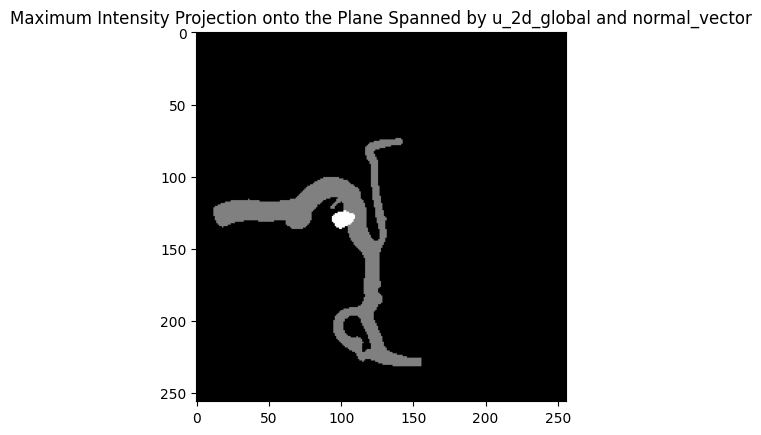

In [ ]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

def project_3D_to_2D_max_intensity(matrix_3D, projection_direction, method="max"):
    """
    Projects a 3D matrix onto a 2D plane by performing a maximum intensity projection
    along a given direction (projection_direction).

    Args:
        matrix_3D (np.ndarray): The 3D volume with different gray values.
        projection_direction (np.ndarray): The direction to project the data along.
        method (str): Projection method - "max" (default), "mean", or "sum".

    Returns:
        np.ndarray: 2D projected matrix.
    """
    # Normalize the projection direction (just in case)
    projection_direction = projection_direction / np.linalg.norm(projection_direction)

    # Compute the axis of projection by finding the dominant axis (x, y, or z)
    axis = np.argmax(np.abs(projection_direction))

    # Perform the maximum intensity projection along the identified axis
    if method == "max":
        projected_2D = np.max(matrix_3D, axis=axis)  # Maximum Intensity Projection
    elif method == "mean":
        projected_2D = np.mean(matrix_3D, axis=axis)  # Mean Projection
    elif method == "sum":
        projected_2D = np.sum(matrix_3D, axis=axis)  # Sum Projection
    else:
        raise ValueError("Invalid method. Choose 'max', 'mean', or 'sum'.")

    return projected_2D

# Step 1: Compute the projection direction
projection_direction = np.cross(normal_vector, u_2d_global)
projection_direction /= np.linalg.norm(projection_direction)  # Normalize
print('Final global projection unit vector: ', projection_direction )

# Step 2: Perform the Maximum Intensity Projection along this direction
projected_2D = project_3D_to_2D_max_intensity(matrix_corr_mask, projection_direction, method="max")

# Step 3: Plot the 2D projection
plt.imshow(projected_2D, cmap='gray')
plt.title("Maximum Intensity Projection onto the Plane Spanned by u_2d_global and normal_vector")
plt.show()

# Projection of the grayscale image

Matrix shape: (256, 256, 256)


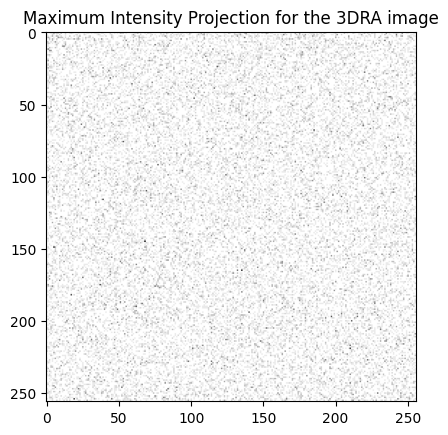

In [ ]:
DRA_image_matrix = construct_matrix(file_path)

# Step 2: Perform the Maximum Intensity Projection along this direction
projected_2D = project_3D_to_2D_max_intensity(DRA_image_matrix, projection_direction, method="max")

# Step 3: Plot the 2D projection
plt.imshow(projected_2D, cmap='gray')
plt.title("Maximum Intensity Projection for the 3DRA image")
plt.show()

# Naive computation of DRA angles

Define the Projection Vector in 3DRA Coordinates:

The Z-axis typically represents the cranio-caudal direction (head to feet).

The Y-axis is the left-right direction.

The X-axis is the anterior-posterior direction.

In [ ]:
# Assuming that the coordinate system is correct
# TODO: ask profs what the coordinate axes in the images actually stand for !!

azim = np.arctan2(projection_direction[1], projection_direction[0])
cran = np.arctan2(projection_direction[2], np.sqrt(projection_direction[0]**2 + projection_direction[1]**2))

azim_degrees = np.degrees(azim)
cran_degrees = np.degrees(cran)

print(f"Azimuth angle: {azim_degrees:.2f} degrees")
print(f"Cranial angle: {cran_degrees:.2f} degrees")

Azimuth angle: 133.63 degrees
Cranial angle: 52.43 degrees
